# Ласкаво прошу до першої частини домашнього завдання №2!

В ній, ви імплементуєте алгоритм Гістограм Орієнтованих Градієнтів та навчите класифікатор зображень на наборі даних CIFAR10.


In [1]:
"""
In this task, you are required to implement the Histograms of Oriented Gradients (HOG) algorithm.
"""

import numpy as np
import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from lib.feature_extractor import FeatureExtractor, BaselineFeatureExtractor
from lib.vis_utils import visualize_dataset_images, visualize_predictions
from lib.dataset import CIFAR10

from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

In [2]:
def calc_accuracy(model, feats, labels):
    preds = model.predict(feats)
    return np.mean(labels == preds)

In [3]:
cifar10 = CIFAR10()
(
    images_train, labels_train,
    images_val, labels_val,
    images_test, labels_test
) = cifar10.load_dataset()

CIFAR10 found.


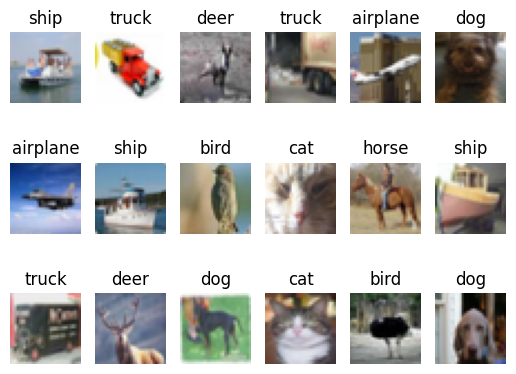

In [4]:
visualize_dataset_images(images_val[:18], labels_val[:18], cifar10.LABEL_NAMES)

# Baseline
Спочатку розглянемо `BaselineFeatureExtractor`. Його імплементація знаходиться в файлі `lib/feature_extractor.py`
Це дуже простий екстрактор ознак, який обчислює середні значення та стандартні відхилення для блоків пікселів 4х4, після чого конкатенує їх у фінальний вектор ознак.

In [5]:
baseline_extractor = BaselineFeatureExtractor()
feats_train = baseline_extractor.extract(images_train)
feats_val = baseline_extractor.extract(images_val)
feats_test = baseline_extractor.extract(images_test)

48999it [00:12, 3999.49it/s]
999it [00:00, 1012.12it/s]
999it [00:00, 1516.72it/s]


Для класифікації зображень використаємо алгоритм К найближчих сусідів.

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X=feats_train, y=labels_train)

In [7]:
tr_acc = calc_accuracy(knn, feats_train, labels_train)
val_acc = calc_accuracy(knn, feats_val, labels_val)
print(f"KNN+baseline_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}.") 

KNN+baseline_extractor. Train accuracy: 0.48359183673469386. Validation accuracy: 0.236.


Як видно, навіть такий простий підхід досягає не найгіршої якості на валідаційній вибірці. Але тепер перейдімо до більш серйозних ознак.

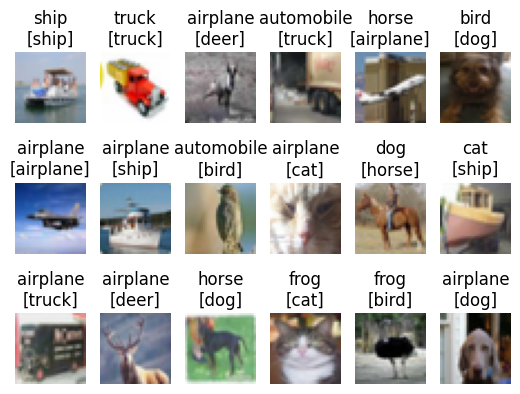

In [8]:
visualize_predictions(images_val[:18], knn.predict(feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Implement Histogram of Oriented Gradients

Вашою першою задачею буде імплементація Гістограми Орієнтованих Градієнтів. `lib/feature_extractor.py:HOGFeatureExtractor`

In [ ]:
from lib.feature_extractor import HOGFeatureExtractor

In [ ]:
hog_extractor = HOGFeatureExtractor()
hog_feats_train = hog_extractor.extract(images_train)
hog_feats_val = hog_extractor.extract(images_val)
hog_feats_test = hog_extractor.extract(images_test)

Знову використаємо К найближчих сусідів для класифікації. Очікується валідаційна точність >=0.40.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X=hog_feats_train, y=labels_train)

tr_acc = calc_accuracy(knn, hog_feats_train, labels_train)
val_acc = calc_accuracy(knn, hog_feats_val, labels_val)
print(f"KNN+hog_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}")

In [ ]:
visualize_predictions(images_val[:18], knn.predict(hog_feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Use SGD Classifer

Тепер спробуємо дещо інший підхід. Вашою задачею є використання `SGDClassifier` з пакета `scikit-learn`. Очікувана точність >=0.41


In [ ]:
# Preprocessing: Subtract the mean feature
train_mean_feat = np.mean(hog_feats_train, axis=0, keepdims=True)
train_std_feat = np.std(hog_feats_train, axis=0, keepdims=True)

def normalize(feats, mean, std):
    return (feats - mean) / (std + 1e-5)

hog_feats_train = normalize(hog_feats_train, train_mean_feat, train_std_feat)
hog_feats_val = normalize(hog_feats_val, train_mean_feat, train_std_feat)
hog_feats_test = normalize(hog_feats_test, train_mean_feat, train_std_feat)

In [ ]:
# TASK: Test SGDClassifer

In [ ]:
visualize_predictions(images_val[:18], model.predict(hog_feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# CIFAR10 challenge

З цих ви вільні імплементувати будь-які модифікації до екстракторів ознак, підбирати гіперпараметри до класифікатора чи використовувати ансамблювання. Вашою задачею є досягти максимальної валідаційної точності.
Ви вільні використовувати нейромережі (`torch`/`sklearn`) або `SGDClassifier`. За використання нейромереж на базі `torch` - +25%, якщо метрика на валідації >=0.5.

При наборі >=0.5, ви додатково отримаєте +10% до балів відносно даного завдання. При наборі >=0.6 - +25%. При наборі >=0.85 - +50%


Таким чином:
```
torch + набiр >=0.85 - +75%
torch + набір >=0.6 - +50%
torch + набір >=0.5 - +35%
набiр >=0.85 - +50%
набір >=0.6 - +25%
набір >=0.5 - +10%
```

Бажаю удачі!